In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import spinesTS
spinesTS.__version__

'0.3.7'

In [3]:
from spinesTS.preprocessing import split_series
from spinesTS.plotting import plot2d
from sklearn.metrics import r2_score

In [4]:
from spinesTS.data import BuiltInSeriesData
from spinesTS.nn import *
from spinesTS.metrics import mean_absolute_error
from spinesTS.metrics import mean_absolute_percentage_error

In [5]:
series_data = BuiltInSeriesData()

+----+----------------------+----------------------------------------------------------------------+
|    | ds name              | columns                                                              |
+----+----------------------+----------------------------------------------------------------------+
|  0 | AirPassengers        | Month, #Passengers                                                   |
|  1 | ETTh1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  2 | ETTh2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  3 | ETTm1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  4 | ETTm2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  5 | Electric_Production  | date, value                                                          |
|  6 | M3_monthly_FTS       | series_id, method_id, forecast, horizon, timestamp, origin_ti

In [6]:
cs = series_data['Web_Sales']

x_train, x_test, y_train, y_test = split_series(cs['type_a'], cs['type_a'], 128, 30, train_size=0.9)

In [7]:
x_train.shape, x_test.shape

((1738, 128), (194, 128))

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

scaler2 = MinMaxScaler()
y_train = scaler2.fit_transform(y_train)
y_test = scaler2.transform(y_test)

# StackingRNN

In [ ]:
model = StackingRNN(128, 30, random_seed=42, loss_fn='mae', learning_rate=0.001, dropout=0.1,
                    device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler=None)
y_pred_inverse = scaler2.inverse_transform(model.predict(x_test))

y_test_inverse = scaler2.inverse_transform(y_test)

print(f"r2: {r2_score(y_test_inverse.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test_inverse, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)}")
a = plot2d(y_test_inverse, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

Using cpu backend
Epoch 1/3000  
55/55 - p0 - loss: 0.2528 - mae: 0.4231 - val_loss: 0.2679 - val_mae: 0.2679 - 1.00s/epoch - 0.018s/step
Epoch 2/3000  
55/55 - p1 - loss: 0.2613 - mae: 0.3421 - val_loss: 0.2828 - val_mae: 0.2828 - 1.02s/epoch - 0.019s/step
Epoch 3/3000  
55/55 - p2 - loss: 0.2802 - mae: 0.3116 - val_loss: 0.3010 - val_mae: 0.3010 - 0.95s/epoch - 0.017s/step
Epoch 4/3000  
55/55 - p3 - loss: 0.2890 - mae: 0.2899 - val_loss: 0.3087 - val_mae: 0.3087 - 1.03s/epoch - 0.019s/step
Epoch 5/3000  
55/55 - p4 - loss: 0.2941 - mae: 0.2699 - val_loss: 0.3133 - val_mae: 0.3133 - 1.14s/epoch - 0.021s/step
Epoch 6/3000  
55/55 - p5 - loss: 0.2936 - mae: 0.2527 - val_loss: 0.3129 - val_mae: 0.3129 - 1.12s/epoch - 0.020s/step
Epoch 7/3000  
55/55 - p6 - loss: 0.2916 - mae: 0.2382 - val_loss: 0.3104 - val_mae: 0.3104 - 1.08s/epoch - 0.020s/step
Epoch 8/3000  
55/55 - p7 - loss: 0.2843 - mae: 0.2222 - val_loss: 0.3031 - val_mae: 0.3031 - 0.97s/epoch - 0.018s/step
Epoch 9/3000  
55/55 -

Using cpu backend
Epoch 1/3000  
7/7 - p0 - loss: 0.2141 - mae: 0.3957 - val_loss: 0.2250 - val_mae: 0.2250 - 0.07s/epoch - 0.010s/step
Epoch 2/3000  
7/7 - p0 - loss: 0.2108 - mae: 0.2661 - val_loss: 0.1746 - val_mae: 0.1746 - 0.06s/epoch - 0.009s/step
Epoch 3/3000  
7/7 - p0 - loss: 0.1676 - mae: 0.2490 - val_loss: 0.1423 - val_mae: 0.1423 - 0.06s/epoch - 0.009s/step
Epoch 4/3000  
7/7 - p0 - loss: 0.1353 - mae: 0.1877 - val_loss: 0.1333 - val_mae: 0.1333 - 0.06s/epoch - 0.009s/step
Epoch 5/3000  
7/7 - p1 - loss: 0.1286 - mae: 0.1557 - val_loss: 0.1363 - val_mae: 0.1363 - 0.06s/epoch - 0.008s/step
Epoch 6/3000  
7/7 - p0 - loss: 0.1454 - mae: 0.1473 - val_loss: 0.1216 - val_mae: 0.1216 - 0.06s/epoch - 0.009s/step
Epoch 7/3000  
7/7 - p0 - loss: 0.1097 - mae: 0.1194 - val_loss: 0.1133 - val_mae: 0.1133 - 0.06s/epoch - 0.009s/step
Epoch 8/3000  
7/7 - p0 - loss: 0.1086 - mae: 0.1190 - val_loss: 0.1131 - val_mae: 0.1131 - 0.06s/epoch - 0.009s/step
Epoch 9/3000  
7/7 - p0 - loss: 0.0977

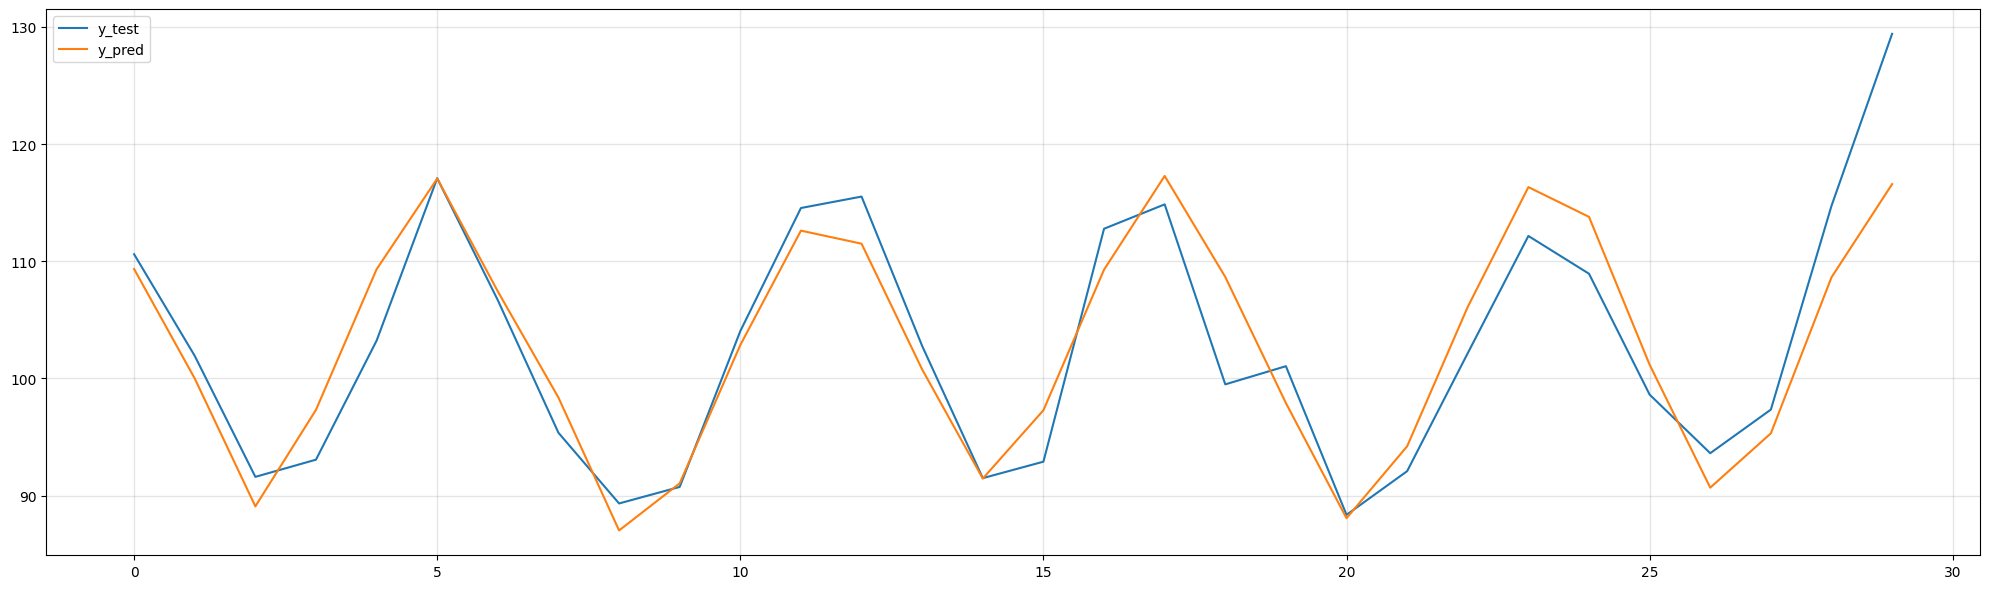

In [17]:
model = StackingRNN(128, 30, random_seed=42, loss_fn='mae', learning_rate=0.001, dropout=0.1,
                    device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler=None)
y_pred_inverse = scaler2.inverse_transform(model.predict(x_test))

y_test_inverse = scaler2.inverse_transform(y_test)

print(f"r2: {r2_score(y_test_inverse.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test_inverse, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)}")
a = plot2d(y_test_inverse, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

# GAUNet

Using cpu backend
Epoch 1/3000  
7/7 - p0 - loss: 0.3526 - mae: 0.3783 - val_loss: 0.3122 - val_mae: 0.3122 - 0.05s/epoch - 0.007s/step
Epoch 2/3000  
7/7 - p0 - loss: 0.2326 - mae: 0.2113 - val_loss: 0.2372 - val_mae: 0.2372 - 0.03s/epoch - 0.005s/step
Epoch 3/3000  
7/7 - p1 - loss: 0.2297 - mae: 0.1759 - val_loss: 0.2436 - val_mae: 0.2436 - 0.03s/epoch - 0.004s/step
Epoch 4/3000  
7/7 - p0 - loss: 0.1822 - mae: 0.1527 - val_loss: 0.1955 - val_mae: 0.1955 - 0.03s/epoch - 0.005s/step
Epoch 5/3000  
7/7 - p0 - loss: 0.1441 - mae: 0.1343 - val_loss: 0.1508 - val_mae: 0.1508 - 0.03s/epoch - 0.004s/step
Epoch 6/3000  
7/7 - p0 - loss: 0.1338 - mae: 0.1235 - val_loss: 0.1395 - val_mae: 0.1395 - 0.03s/epoch - 0.005s/step
Epoch 7/3000  
7/7 - p0 - loss: 0.1271 - mae: 0.1117 - val_loss: 0.1371 - val_mae: 0.1371 - 0.03s/epoch - 0.005s/step
Epoch 8/3000  
7/7 - p0 - loss: 0.1114 - mae: 0.1005 - val_loss: 0.1214 - val_mae: 0.1214 - 0.04s/epoch - 0.005s/step
Epoch 9/3000  
7/7 - p0 - loss: 0.1040

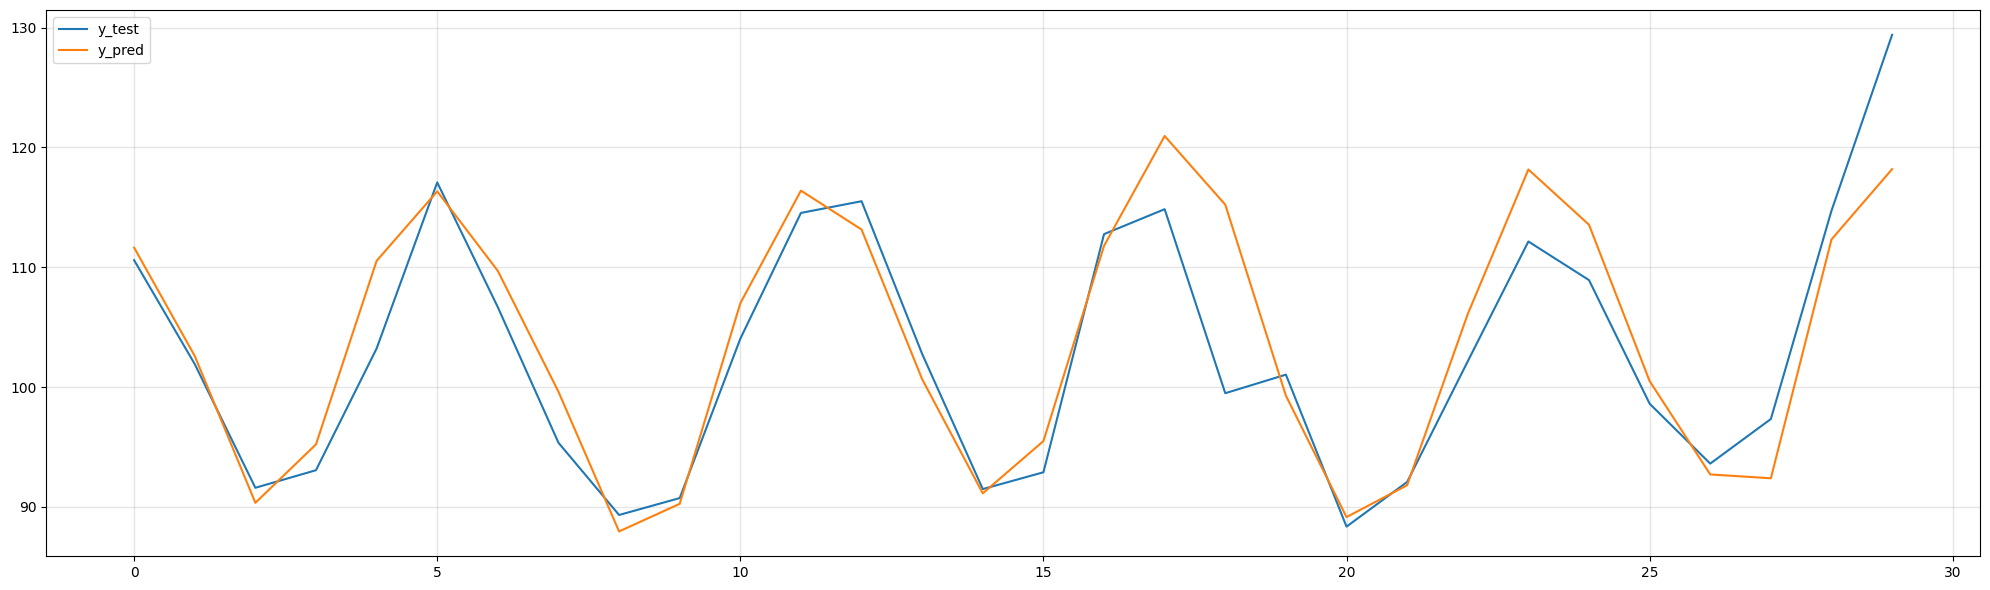

In [19]:
model = GAUNet(128, 30, random_seed=42, flip_features=False, learning_rate=0.001, level=2, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler=None)
y_pred_inverse = scaler2.inverse_transform(model.predict(x_test))
y_test_inverse = scaler2.inverse_transform(y_test)

print(f"r2: {r2_score(y_test_inverse.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test_inverse, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)}")
a = plot2d(y_test_inverse, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

# Time2VecNet

Using cpu backend
Epoch 1/3000  
7/7 - p0 - loss: 0.2998 - mae: 0.3687 - val_loss: 0.2898 - val_mae: 0.2898 - 0.04s/epoch - 0.006s/step
Epoch 2/3000  
7/7 - p0 - loss: 0.2420 - mae: 0.2415 - val_loss: 0.2505 - val_mae: 0.2505 - 0.03s/epoch - 0.004s/step
Epoch 3/3000  
7/7 - p0 - loss: 0.2044 - mae: 0.2027 - val_loss: 0.2173 - val_mae: 0.2173 - 0.03s/epoch - 0.004s/step
Epoch 4/3000  
7/7 - p0 - loss: 0.1559 - mae: 0.1566 - val_loss: 0.1842 - val_mae: 0.1842 - 0.03s/epoch - 0.004s/step
Epoch 5/3000  
7/7 - p0 - loss: 0.1354 - mae: 0.1354 - val_loss: 0.1653 - val_mae: 0.1653 - 0.03s/epoch - 0.004s/step
Epoch 6/3000  
7/7 - p0 - loss: 0.1189 - mae: 0.1185 - val_loss: 0.1533 - val_mae: 0.1533 - 0.03s/epoch - 0.004s/step
Epoch 7/3000  
7/7 - p0 - loss: 0.1092 - mae: 0.1068 - val_loss: 0.1476 - val_mae: 0.1476 - 0.03s/epoch - 0.004s/step
Epoch 8/3000  
7/7 - p0 - loss: 0.0950 - mae: 0.0974 - val_loss: 0.1396 - val_mae: 0.1396 - 0.03s/epoch - 0.004s/step
Epoch 9/3000  
7/7 - p0 - loss: 0.0892

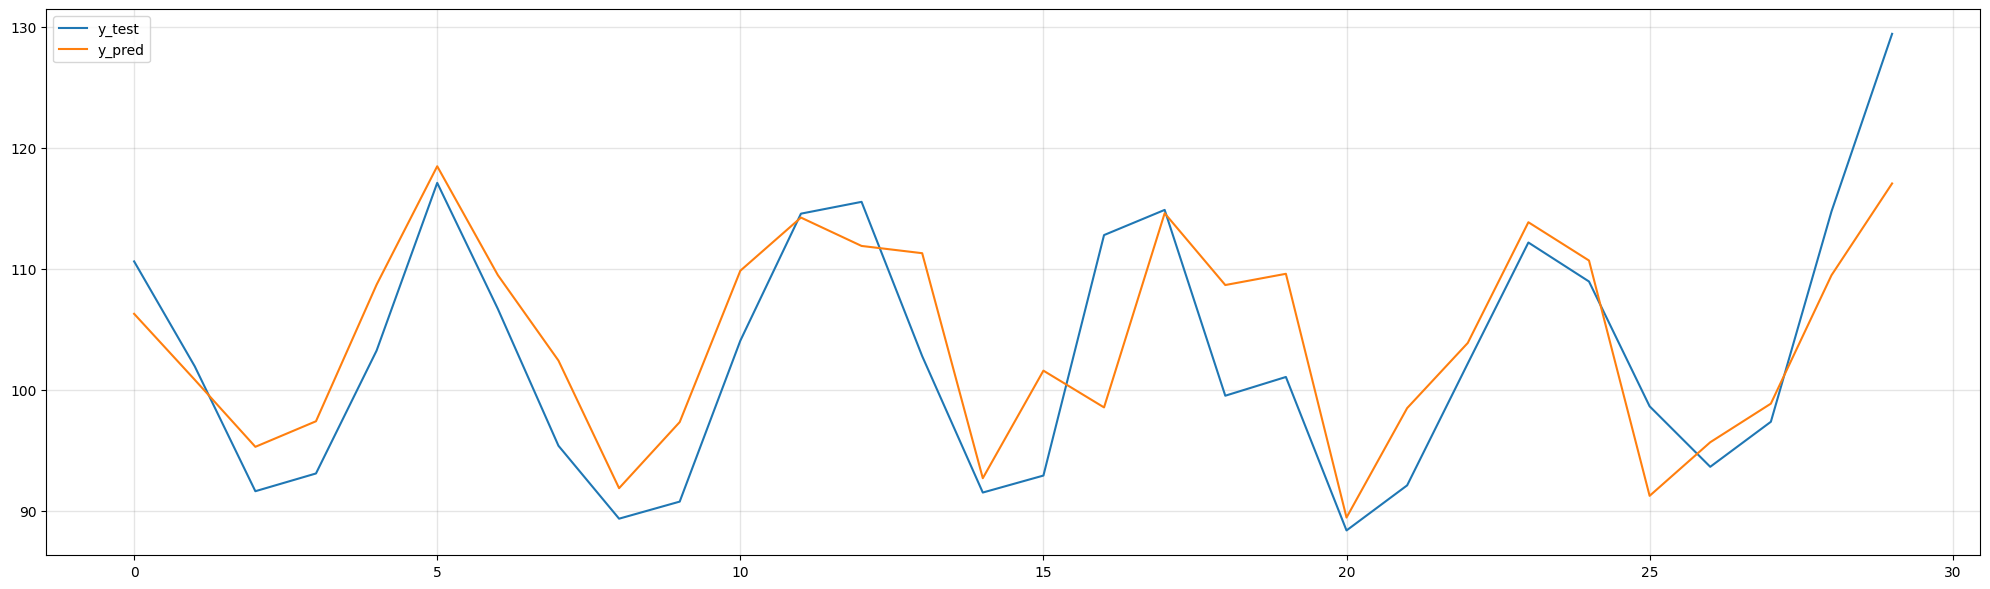

In [20]:
model = Time2VecNet(128, 30, random_seed=42, flip_features=False, learning_rate=0.001, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler='ReduceLROnPlateau')

y_pred_inverse = scaler2.inverse_transform(model.predict(x_test))
y_test_inverse = scaler2.inverse_transform(y_test)

print(f"r2: {r2_score(y_test_inverse.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test_inverse, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)}")
a = plot2d(y_test_inverse, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))